### **LESSON 4: EXPONENTIALLY WEIGHTED DYNAMICS FOR THE PRISONER'S DILEMMA**

Install packages used in this code.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import nashpy as nash
import math
import copy

Define a game of Prisoner's Dilemma by using Nashpy.
In this game, we consider (x1D, x2C) where x1D and x2C are respectively the probability of Player 1 and Player 2 choosing the pure action D and C.

In [2]:
# Create the game with the payoff matrix
A = np.array([[-1,-5], [0, -3]]) # A is the payoff matrix of Player 1 (the column player - Julian)
B = np.array([[-1,0], [-5, -3]]) # B is the payoff matrix of Player 2 (the row player - Thomas)
game = nash.Game(A,B)  # create a game with the input of the payoff matrices of two players.

# **Exponential Weights Algorithm (EWA) with mixed payoff vector feedback**



---


**Initialize**: $y_{i,1} \in \mathbb{R}^{\mathcal{A}_{i}}$, $i=1,\ldots,N$ and step-sizes $\{\gamma_n\}$.

For all epoch $n=1,2,\ldots$, for all players $i \in \mathcal{N}$ do

*   Set $x_{i,n} \propto \exp(y_{i,n})$.
*   Get $\hat{v}_{i,n} = v_{i}(x_{i,n},x_{-i,n}) \in \mathbb{R}^{\mathcal{A}_{i}}$.
*   Set $y_{i,n+1} \longleftarrow y_{i,n} + \gamma_n \hat{v}_{i,n}$.



---
Recall this game has two actions: C(ooperate) and D(efect).

Attention: $x_{i,n} \propto \exp(y_{i,n})$ means that
  * Player 1 updates $x_{1,n,D} =  \dfrac{\exp(y_{1,n,D})}{\exp(y_{1,n,C}) + \exp(y_{1,n,D})}$.

  * Player 2 updates $x_{2,n,C} =  \dfrac{\exp(y_{2,n,C})}{\exp(y_{2,n,C}) + \exp(y_{2,n,D})}$.

Note that $x_{i,n,C} + x_{i,n,D} = 1$ for all player $i \in \mathcal{N}$ and epoch $n$.

In [ ]:
from typing import Literal


def set_mixed_strategy(y):
  x1D = np.exp(y[0][1]) / (np.exp(y[0][0]) + np.exp(y[0][1]))
  x2C = np.exp(y[1][0]) / (np.exp(y[1][0]) + np.exp(y[1][1]))

  return np.array([[1-x1D, x1D], [x2C, 1-x2C]])

def compute_payoff(game, x_n, 
                   feedback_type: Literal['mixed_vector', 'pure_vector', 'bandit']):
  
  if feedback_type == 'mixed_vector':
    # np.matmul: calculate matrix product of two arrays.
    v1n = np.matmul(game.payoff_matrices[0], x_n[1])
    v2n = np.matmul(game.payoff_matrices[1].T, x_n[0])
  else:
    action_0 = 0
    action_1 = 0
  return np.array([v1n, v2n])

def EWA(game, y_0=np.array([[0, 0], [0, 0]]), nIterations=10, gamma_n=1):
  # create a list to save all the solutions x at each epoch
  x = []

  # initialization
  y_n = y_0

  # for all epoch
  for _ in range(nIterations):
    # set mix strategy
    x_n = set_mixed_strategy(y_n)
    # compute payoffs
    v_n = compute_payoff(game, x_n)
    # update scores
    y_n = y_n + gamma_n * v_n

    # save the solution
    x.append(x_n)

  return np.array(x)

**Run EWA for the Prisoner's Dilemma game** with $100$ epochs (or iterations), the step-size of $1$, and the starting values ($n = 0$) of action scores $y_0 = y_n = [[y_{1,n,C}, y_{1,n,D}], [y_{2,n,C}, y_{2,n,D}]] = [[0, 0], [0, 0]]$.


In [ ]:
x_sols = EWA(game,y_0=[[0, 0], [0, 0]], nIterations= 100, gamma_n=0.1)
print(x_sols[0:100,:])  # just print the 10 first elements

In [12]:
x_sols[99]

array([[3.88774335e-09, 9.99999996e-01],
       [3.88774329e-09, 9.99999996e-01]])

# **Plot the discrete-time results and compare them with the continuous time (obtained from Lesson 3)**

**Probability distribution of strategies over time for Players** (codes from previous lessons)

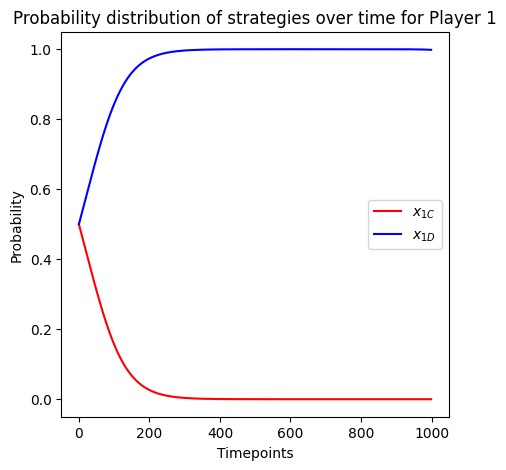

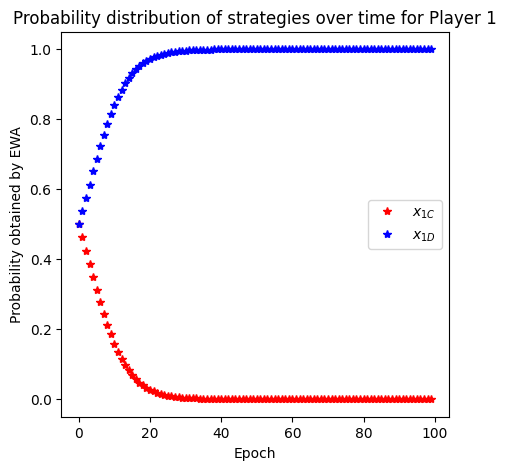

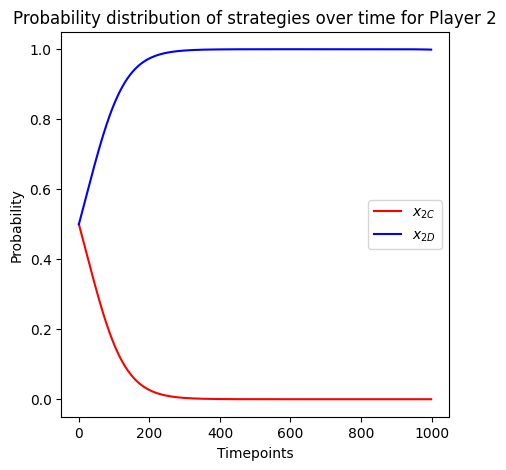

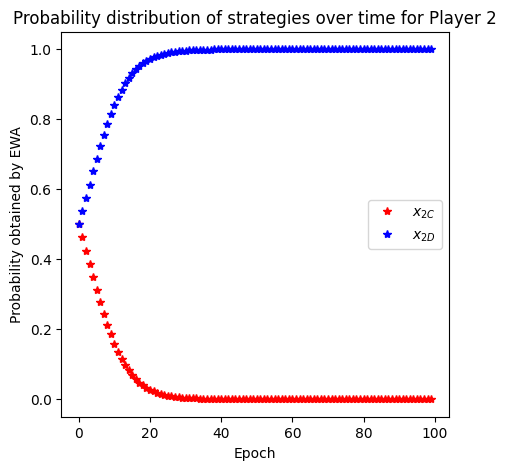

In [ ]:
# Set the initial probabilities of each player
# x0 = [x01, x02] and y0=[y01, y02]
x01 = 0.5       # the probability of Player 1 for action 1 (action C)
x02 = 1 - x01   # the probability of Player 1 for action 2 (action D)
y01 = 0.5       # the probability of Player 2 for action 1 (action C)
y02 = 1 - y01   # the probability of Player 2 for action 2 (action D)

# Find the replicator dynamics with initial probabilities x0 and y0
xs, ys = game.asymmetric_replicator_dynamics(
    x0=np.array([x01, x02]), y0=np.array([y01, y02]))


# Solution by nashpy
plt.figure(figsize=(5, 5))
plt.gca().set_prop_cycle(color=['red', 'blue', 'green', 'yellow'])
plt.plot(xs)
plt.xlabel("Timepoints")
plt.ylabel("Probability")
plt.title("Probability distribution of strategies over time for Player 1")
plt.legend(["$x_{1C}$", "$x_{1D}$"])
plt.show()

plt.figure(figsize=(5, 5))
plt.plot(x_sols[:, 0, 0], 'r*', x_sols[:, 0, 1], 'b*')  # x_sols[:, 0] for the x1D
plt.xlabel("Epoch")
plt.ylabel("Probability obtained by EWA")
plt.title("Probability distribution of strategies over time for Player 1")
plt.legend(["$x_{1C}$", "$x_{1D}$"])
plt.show()

plt.figure(figsize=(5, 5))
# set color of lines
plt.gca().set_prop_cycle(color=['red', 'blue', 'green', 'yellow'])

plt.plot(ys)
plt.xlabel("Timepoints")
plt.ylabel("Probability")
plt.title("Probability distribution of strategies over time for Player 2")
plt.legend(["$x_{2C}$", "$x_{2D}$"])

plt.figure(figsize=(5, 5))
plt.plot(x_sols[:, 1, 0], 'r*', x_sols[:, 1, 1], 'b*')
plt.xlabel("Epoch")
plt.ylabel("Probability obtained by EWA")
plt.title("Probability distribution of strategies over time for Player 2")
plt.legend(["$x_{2C}$", "$x_{2D}$"])

